In [1]:
import cv2
import numpy as np
import glob

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## 一些基本函数

In [2]:
# 将图像分块，分成 n*n，仅适用于长宽一致的图像
def divide_img(image, interval):
    h, w = image.shape
    assert h == w, "The height != width."
    
    end = h // interval
    subs = []

    for i in range(end):
        for j in range(end):
            sub = image[interval*i:interval*(i+1),interval*j:interval*(j+1)]
            subs.append(sub)
    return subs

# 将图像合并，合并 n*n，仅适用于长宽一致的图像
def merge_image(sub_images, image, interval):
    h, w = image.shape
    new_image = np.zeros((h, w))
    end = h // interval
    num = 0
    for i in range(end):
        for j in range(end):
            new_image[interval*i:interval*(i+1),interval*j:interval*(j+1)] = sub_images[num]
            num += 1
    return new_image

def compute_psnr(img_in, img_sam):
    assert img_in.shape == img_sam.shape, "The sample image's shape is not same as the input!"
    
    mse = np.mean( (img_in/255. - img_sam/255.) ** 2 )
    if mse < 1.0e-10:
        return 100
    return 20 * np.log10(1 / np.sqrt(mse))

def merge_dct(sub_images):
    res = []
    for sub_image in sub_images:
        temp_dct = cv2.dct(sub_image)
        res.append(temp_dct)
    return np.array(res)

def merge_idct(sub_images):
    res = []
    for sub_image in sub_images:
        temp_dct = cv2.idct(sub_image)
        res.append(temp_dct)
    return np.array(res)

## 实验要求

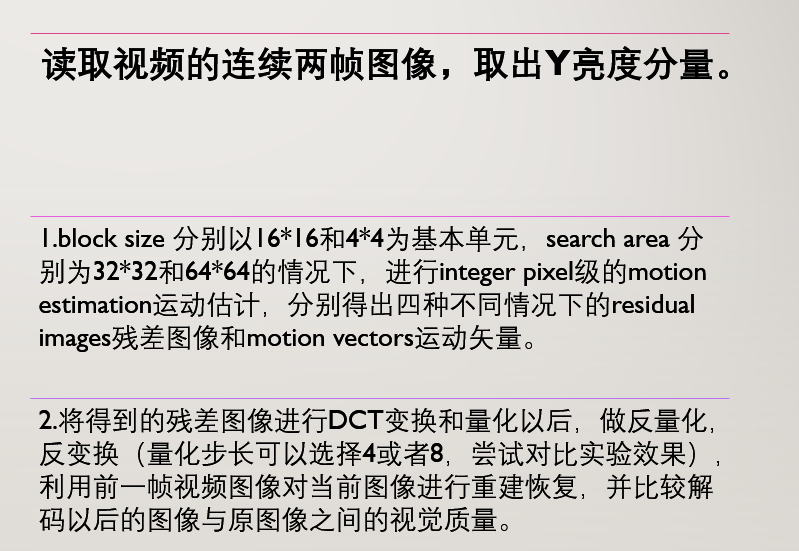

## 1. 截取两帧图像

In [3]:
# video_full_path="./videoData/data.flv"
# cap  = cv2.VideoCapture(video_full_path)
# print(cap.isOpened())

# num = 1
# for _ in range(2):
#     success, frame = cap.read()
 
#     params = []
#     params.append(1)
#     cv2.imwrite(f"videoData/capture_{num}.jpg", frame, params)
 
#     num += 1

# cap.release()

## 2. 读取图像

### 2.1 显示两帧图像

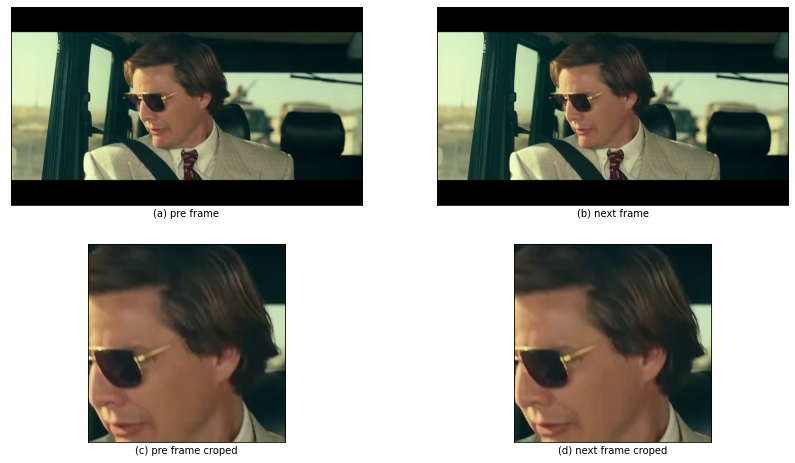

In [4]:
image_files = glob.glob('./videoData/*.jpg')
capture_1_ori = cv2.imread(image_files[0])
capture_2_ori = cv2.imread(image_files[1])

capture_1 = capture_1_ori[200:712, 700:1212]
capture_2 = capture_2_ori[200:712, 700:1212]

plt.figure(figsize=(14,8))

plt.subplot(221)
plt.xticks([])
plt.yticks([])
plt.xlabel('(a) pre frame')
plt.imshow(capture_1_ori[...,::-1])

plt.subplot(222)
plt.xticks([])
plt.yticks([])
plt.xlabel('(b) next frame')
plt.imshow(capture_2_ori[...,::-1])

plt.subplot(223)
plt.xticks([])
plt.yticks([])
plt.xlabel('(c) pre frame croped')
plt.imshow(capture_1[...,::-1])

plt.subplot(224)
plt.xticks([])
plt.yticks([])
plt.xlabel('(d) next frame croped')
plt.imshow(capture_2[...,::-1])

In [5]:
width, height, channel = capture_1.shape
print(f'The shape of image is {capture_1.shape}')

The shape of image is (512, 512, 3)


### 2.2 显示转换为YCrCb后的Y通道图像

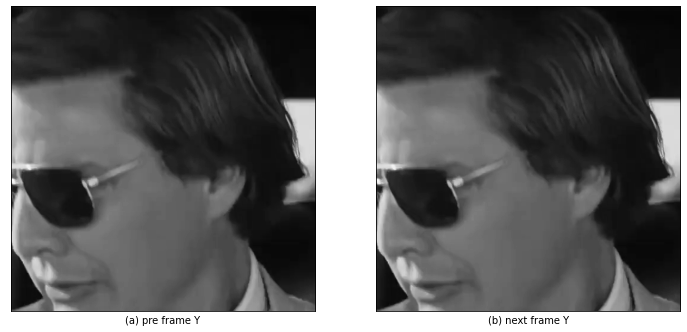

In [6]:
capture_1_Ycrcb = cv2.cvtColor(capture_1, cv2.COLOR_BGR2YCrCb)
capture_2_Ycrcb = cv2.cvtColor(capture_2, cv2.COLOR_BGR2YCrCb)

capture_1_Y, capture_1_Cb, capture_1_Cr = cv2.split(capture_1_Ycrcb)
capture_2_Y, capture_2_Cb, capture_2_Cr = cv2.split(capture_2_Ycrcb)

plt.figure(figsize=(12,6))

plt.subplot(121)
# plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.xlabel('(a) pre frame Y')
plt.imshow(capture_1_Y, cmap='gray')

plt.subplot(122)
plt.xticks([])
plt.yticks([])
# plt.axis('off')
plt.xlabel('(b) next frame Y')
plt.imshow(capture_2_Y, cmap='gray')

---

In [7]:
capture_1_Y.shape

(512, 512)

## 3. 运动估计

### 3.1 构造矩阵，用于遍历

In [8]:
# block_sizes = 4
# search_areas = 32

# interval = (search_areas-block_sizes)//2
# mask_image_1 = np.zeros((width + interval*2, height + interval*2))
# mask_image_1[interval:mask_image_1.shape[0]-interval, interval:mask_image_1.shape[1]-interval] = capture_1_Y

# mask_width, mask_height = mask_image_1.shape
# # mask_image_1.shape,
# print(mask_image_1)

In [9]:
def mse(x, y):
    return np.linalg.norm(x - y)

def mad(tBlock, aBlock):
    """
    Returns Mean Absolute Difference between current frame macroblock (tBlock) and anchor frame macroblock (aBlock)
    """
    return np.sum(np.abs(np.subtract(tBlock, aBlock)))/(tBlock.shape[0]*tBlock.shape[1])

### 3.2 获取预测图像以及运动矢量

In [10]:
def get_preimage_motions(width, height, block_sizes, search_areas):

    width_num = width // block_sizes
    height_num = height // block_sizes
    # 运动向量个数
    vet_nums = width_num * height_num
    # 用来保存运动向量，保存坐标值
    motion_vectors = []
    # 先赋予空值
    motion_vectors = [[0, 0] for _ in range(vet_nums)]
    motion_vectors_for_draw = [[0, 0, 0, 0] for _ in range(vet_nums)]
    
    similarity = 0
    num = 0
    end_num = search_areas//block_sizes
    
    # 计算间隔，用于补0
    interval = (search_areas-block_sizes)//2
    # 构造模板图像，对于上一帧图像加0
    mask_image_1 = np.zeros((width + interval*2, height + interval*2))
    mask_image_1[interval:mask_image_1.shape[0]-interval, interval:mask_image_1.shape[1]-interval] = capture_1_Y

    mask_width, mask_height = mask_image_1.shape

    predict_image = np.zeros(capture_1_Y.shape)    
    
#     count = 0
    for i in range(height_num):
        for j in range(width_num):
#             count += 1
    #         print(f'==================i:{i}=j:{j}==count:{count}=====================')
            temp_image = capture_2_Y[i*block_sizes:(i+1)*block_sizes, j*block_sizes:(j+1)*block_sizes]
            mask_image = mask_image_1[i*block_sizes:i*block_sizes+search_areas, j*block_sizes:j*block_sizes+search_areas]
            #  给定初值，用于比较
            temp_res = mad(mask_image[:block_sizes, :block_sizes], temp_image)
            for k in range(end_num):
                for h in range(end_num):
                    # 取一个模板
                    temp_mask = mask_image[k*block_sizes:(k+1)*block_sizes, h*block_sizes:(h+1)*block_sizes]
                    # 计算mad
                    res = mad(temp_mask, temp_image)
                    # 比较，如果大于默认值，则将其设为默认值，并将预测图像赋值，替代当前运动矢量
                    if res <= temp_res:
                        temp_res = res
                        motion_vectors[i*j+j][0], motion_vectors[i*j+j][1] = k, h
                        motion_vectors_for_draw[i*j+j][0], motion_vectors_for_draw[i*j+j][1], motion_vectors_for_draw[i*j+j][2], motion_vectors_for_draw[i*j+j][3] = i+k, height_num-(j+h), i+interval/block_sizes, height_num-(j+interval/block_sizes)
                        predict_image[i*block_sizes:(i+1)*block_sizes, j*block_sizes:(j+1)*block_sizes] = temp_mask
#                         print(motion_vectors_for_draw[i*j+j])
    #                 break
    #             break
#             break
#         break
    return np.array(predict_image), np.array(motion_vectors), np.array(motion_vectors_for_draw)

- block_sizes = 4, search_areas = 32

In [11]:
predict_image_4_32, motion_vectors_4_32, motion_vectors_for_draw_4_32 = get_preimage_motions(width, height, 4, 32)

- block_sizes = 4, search_areas = 64

In [12]:
predict_image_4_64, motion_vectors_4_64, motion_vectors_for_draw_4_64 = get_preimage_motions(width, height, 4, 64)

- block_sizes = 16, search_areas = 32

In [13]:
predict_image_16_32, motion_vectors_16_32, motion_vectors_for_draw_16_32 = get_preimage_motions(width, height, 16, 32)

- block_sizes = 16, search_areas = 64

In [14]:
predict_image_16_64, motion_vectors_16_64, motion_vectors_for_draw_16_64 = get_preimage_motions(width, height, 16, 64)

### 3.3 绘制运动矢量

保存的向量还是有些小问题，待改正...

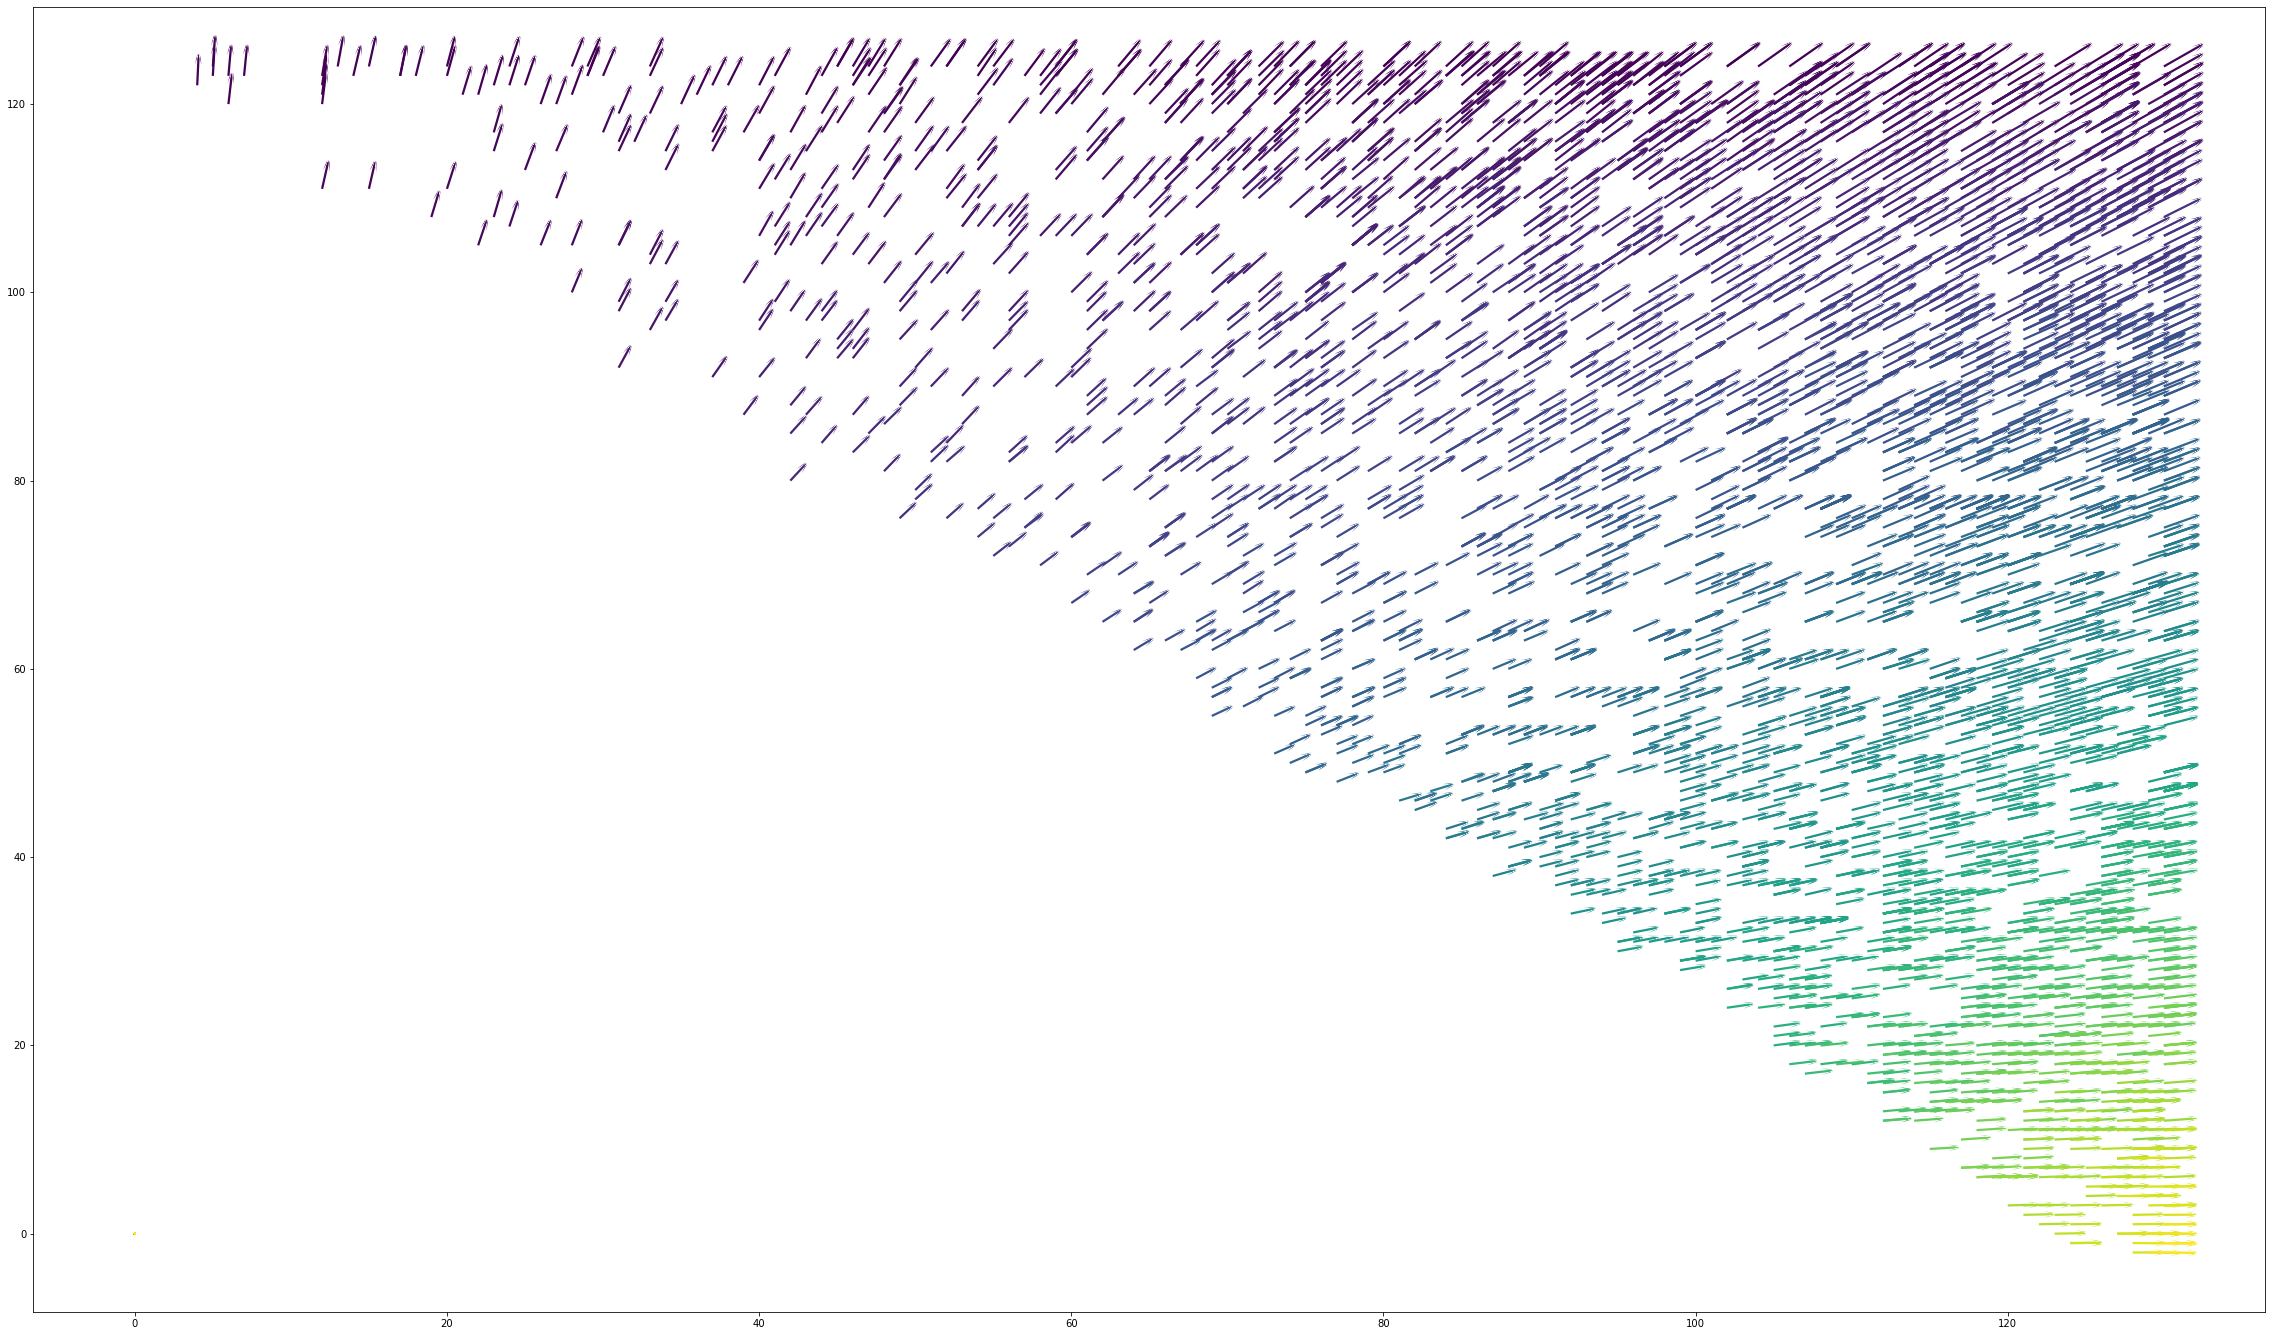

In [15]:
X, Y, U, V = zip(*motion_vectors_for_draw_4_32) 
plt.figure(figsize=(40, 24)) 
ax = plt.gca()
c = np.arange(len(motion_vectors_for_draw_4_32))
ax.quiver(X, Y, U, V, c, angles='xy', headaxislength=0.02, width=0.001) 
plt.draw() 
plt.show()

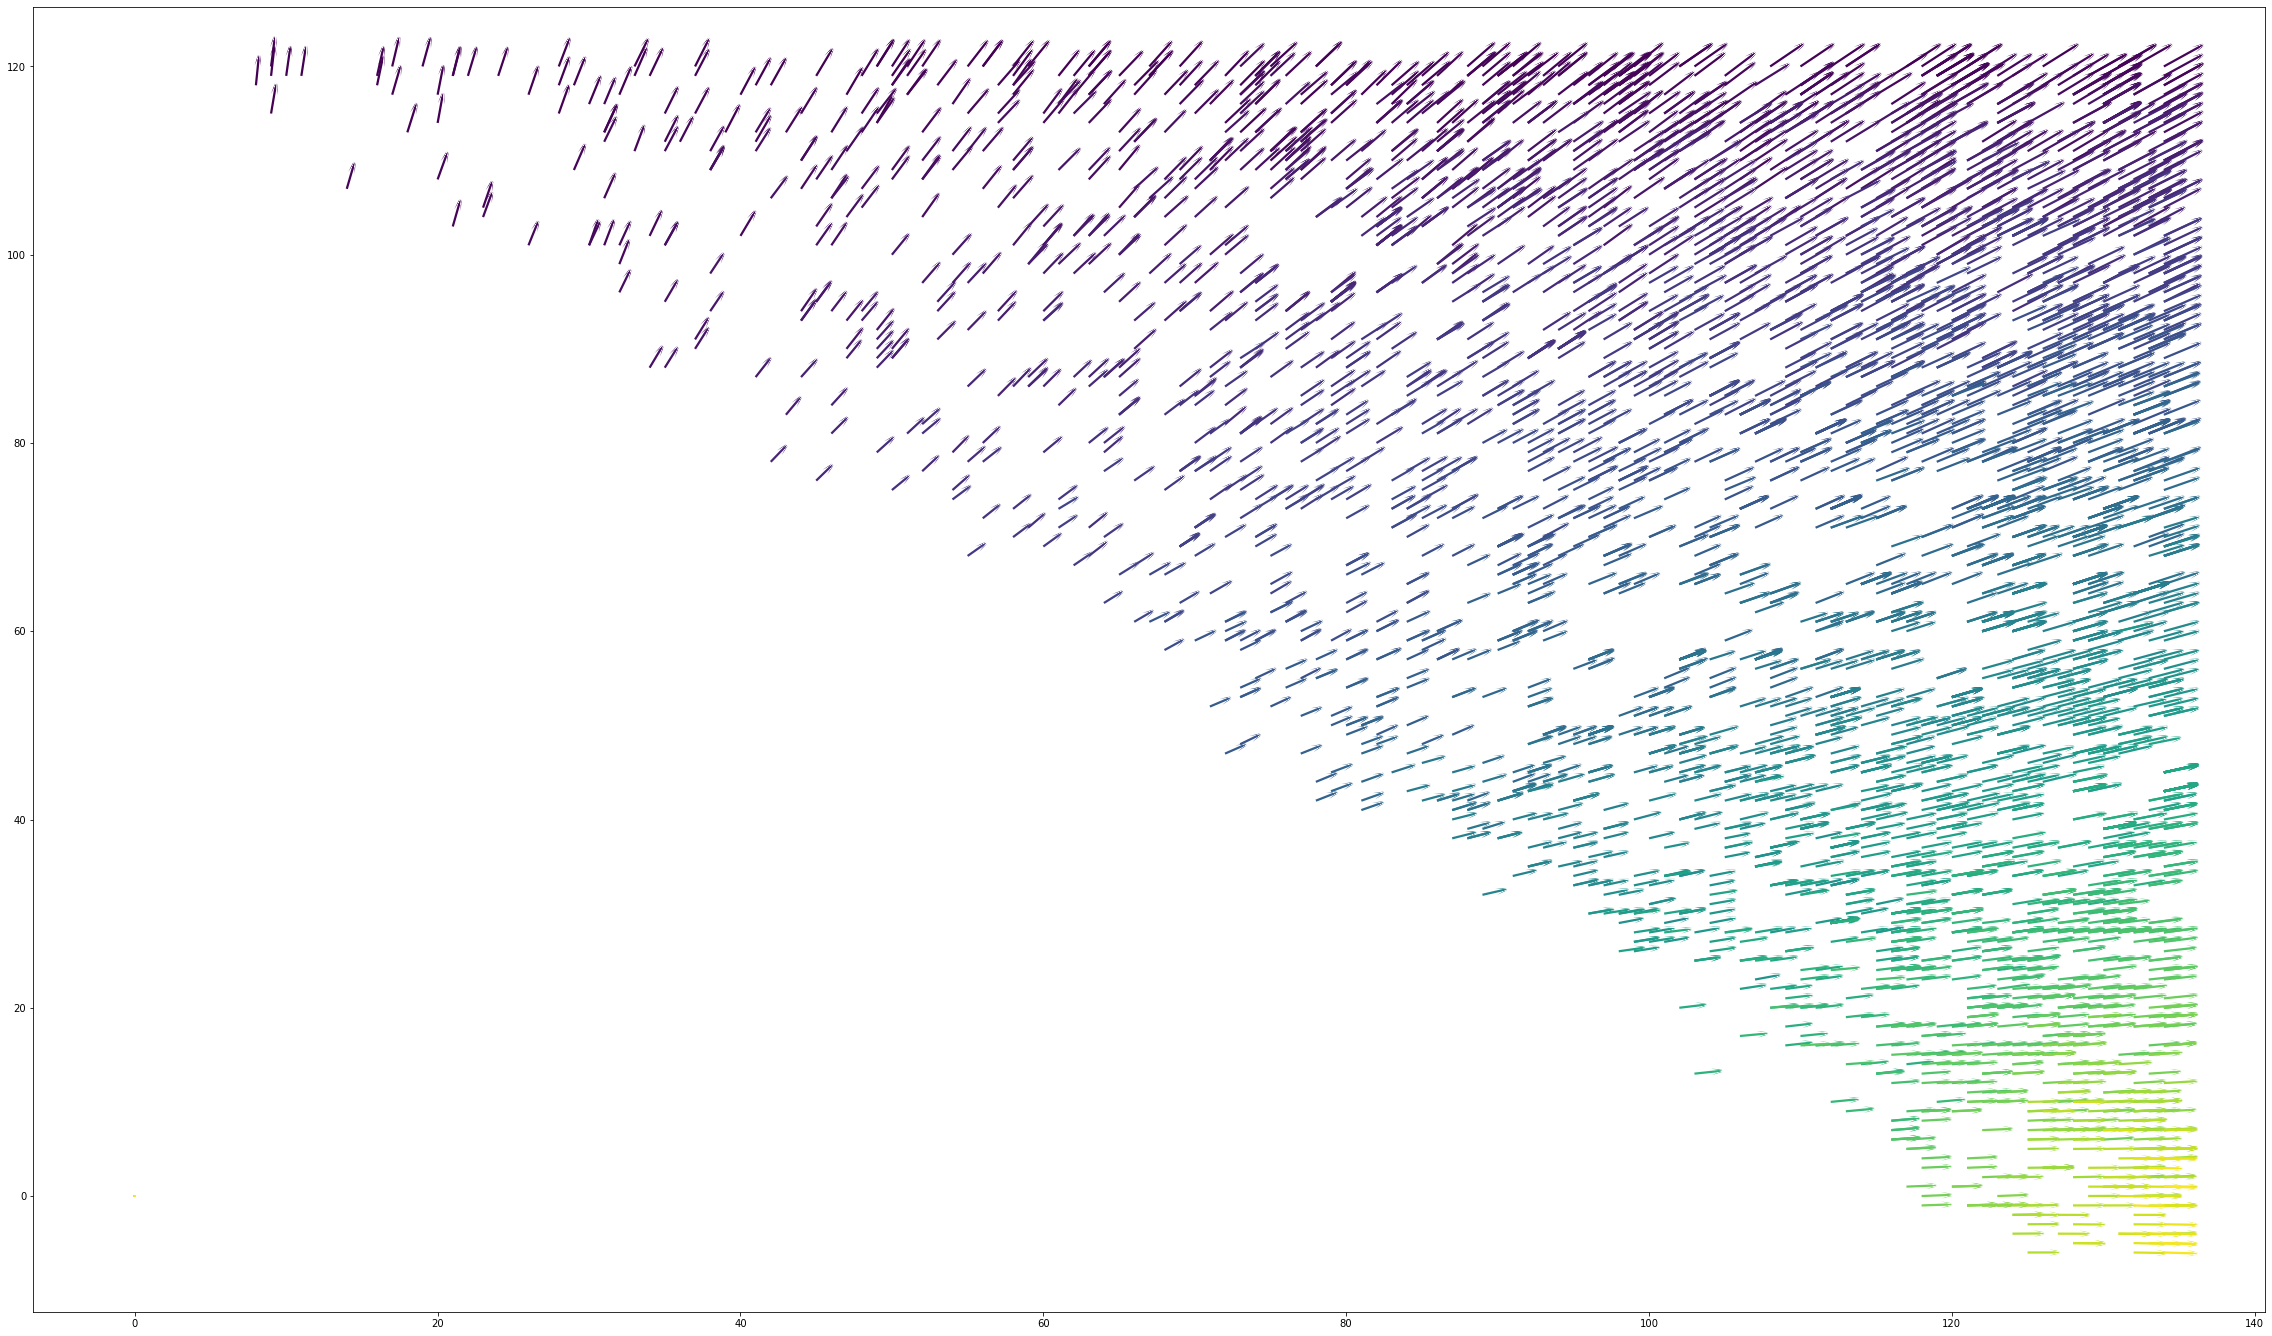

In [16]:
X, Y, U, V = zip(*motion_vectors_for_draw_4_64) 
plt.figure(figsize=(40, 24)) 
ax = plt.gca()
c = np.arange(len(motion_vectors_for_draw_4_64))
ax.quiver(X, Y, U, V, c, angles='xy', headaxislength=0.02, width=0.001) 
plt.draw() 
plt.show()

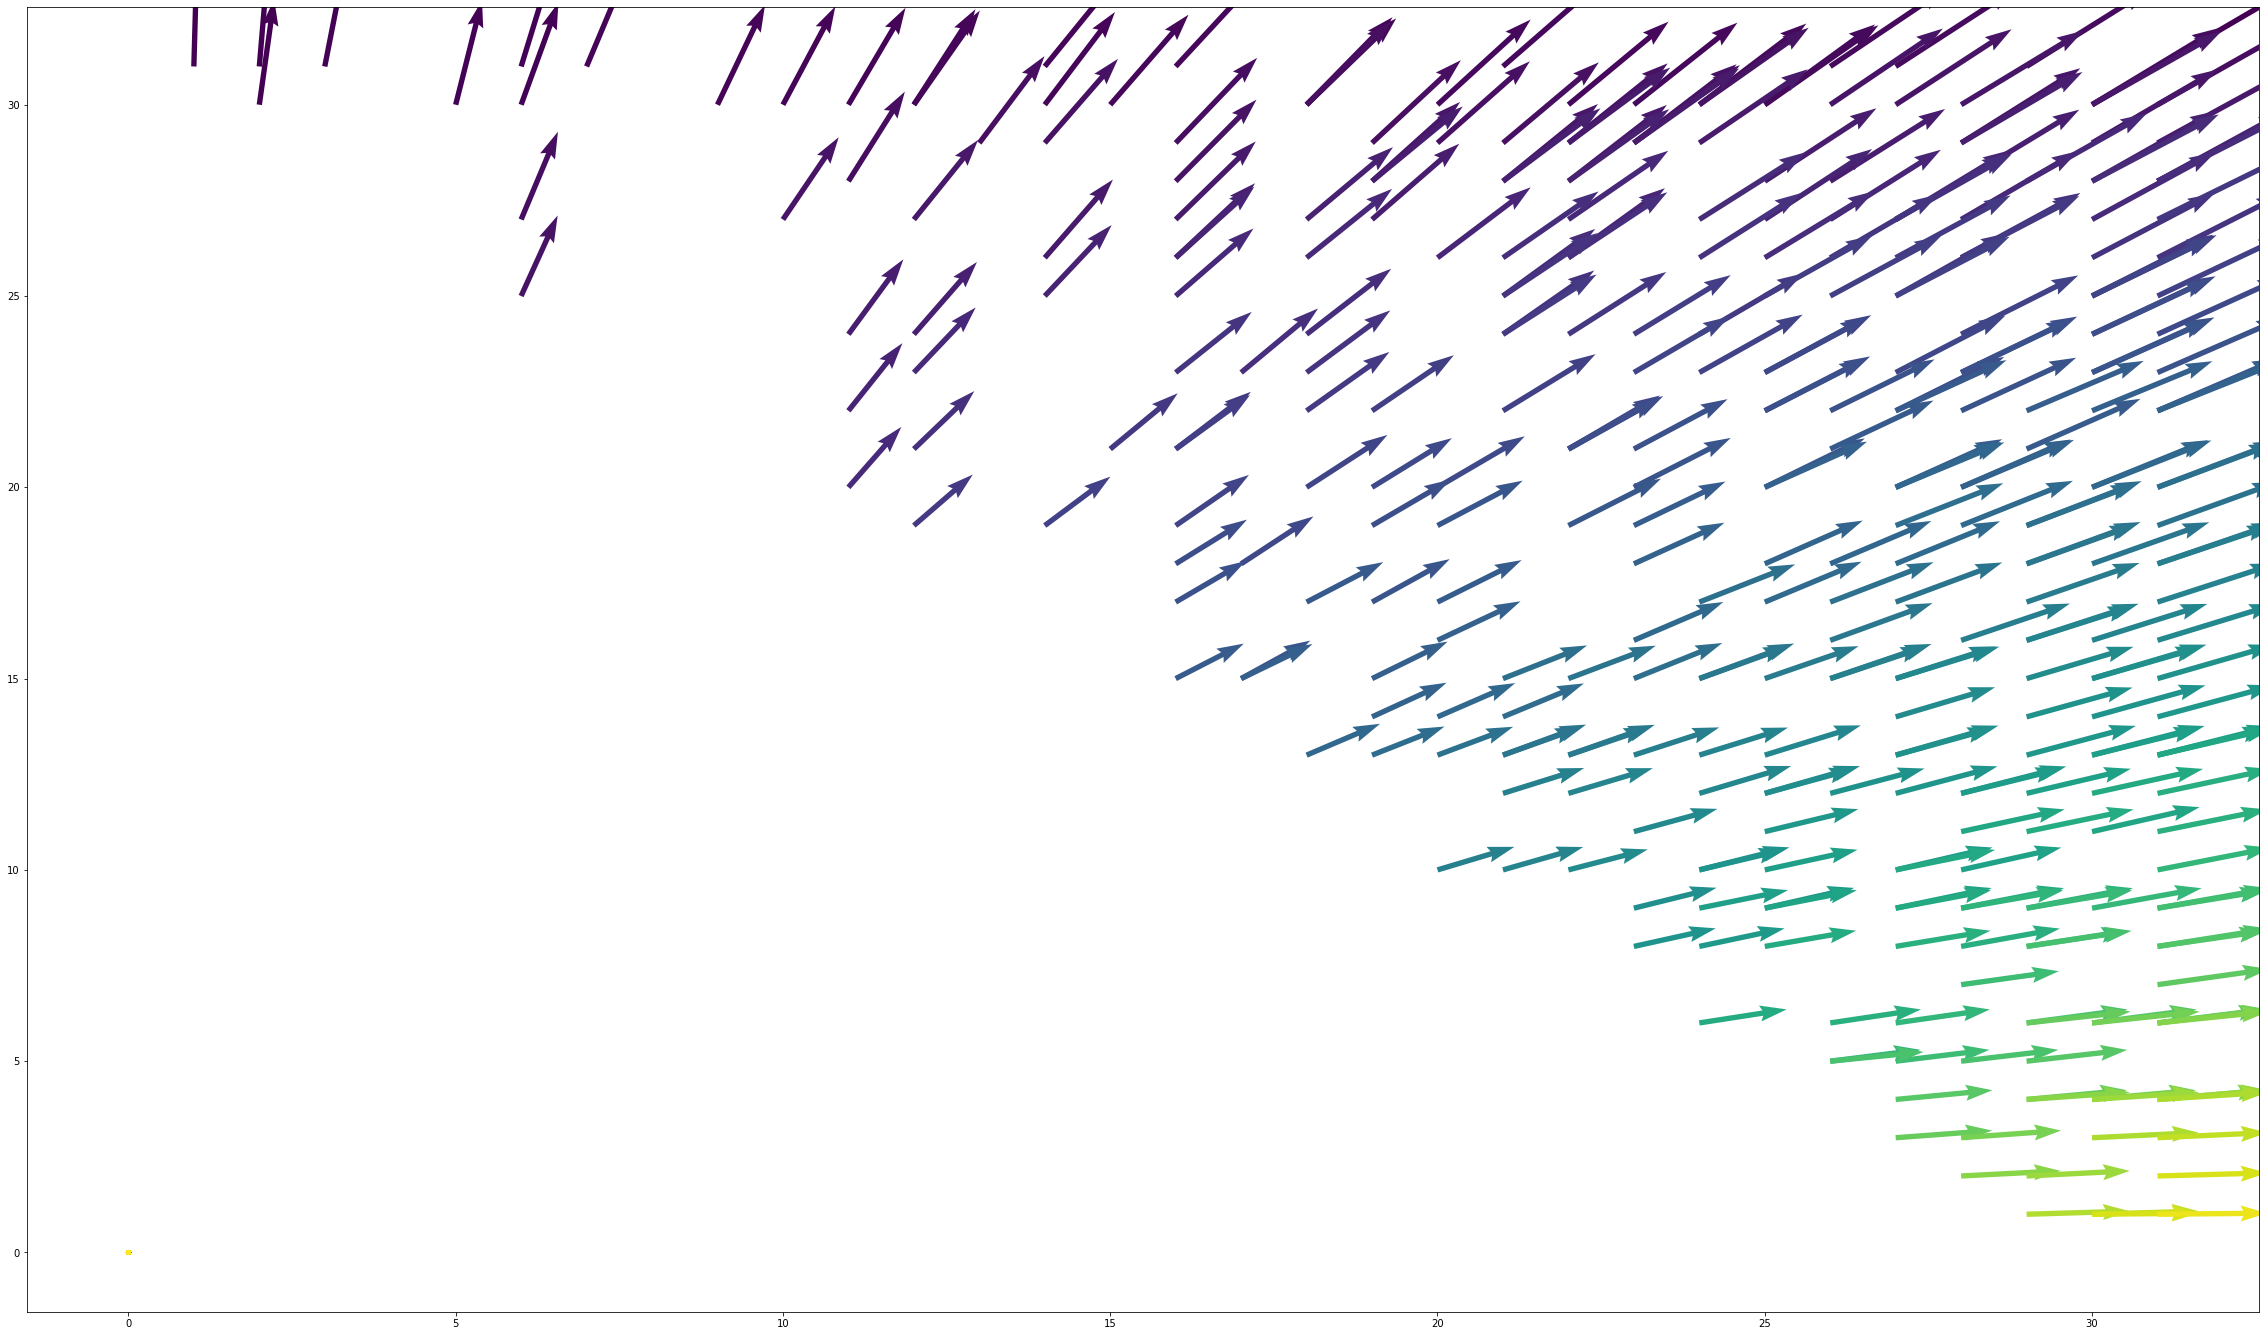

In [17]:
X, Y, U, V = zip(*motion_vectors_for_draw_16_32) 
plt.figure(figsize=(40, 24)) 
ax = plt.gca()
c = np.arange(len(motion_vectors_for_draw_16_32))
ax.quiver(X, Y, U, V, c, angles='xy') 
plt.draw() 
plt.show()

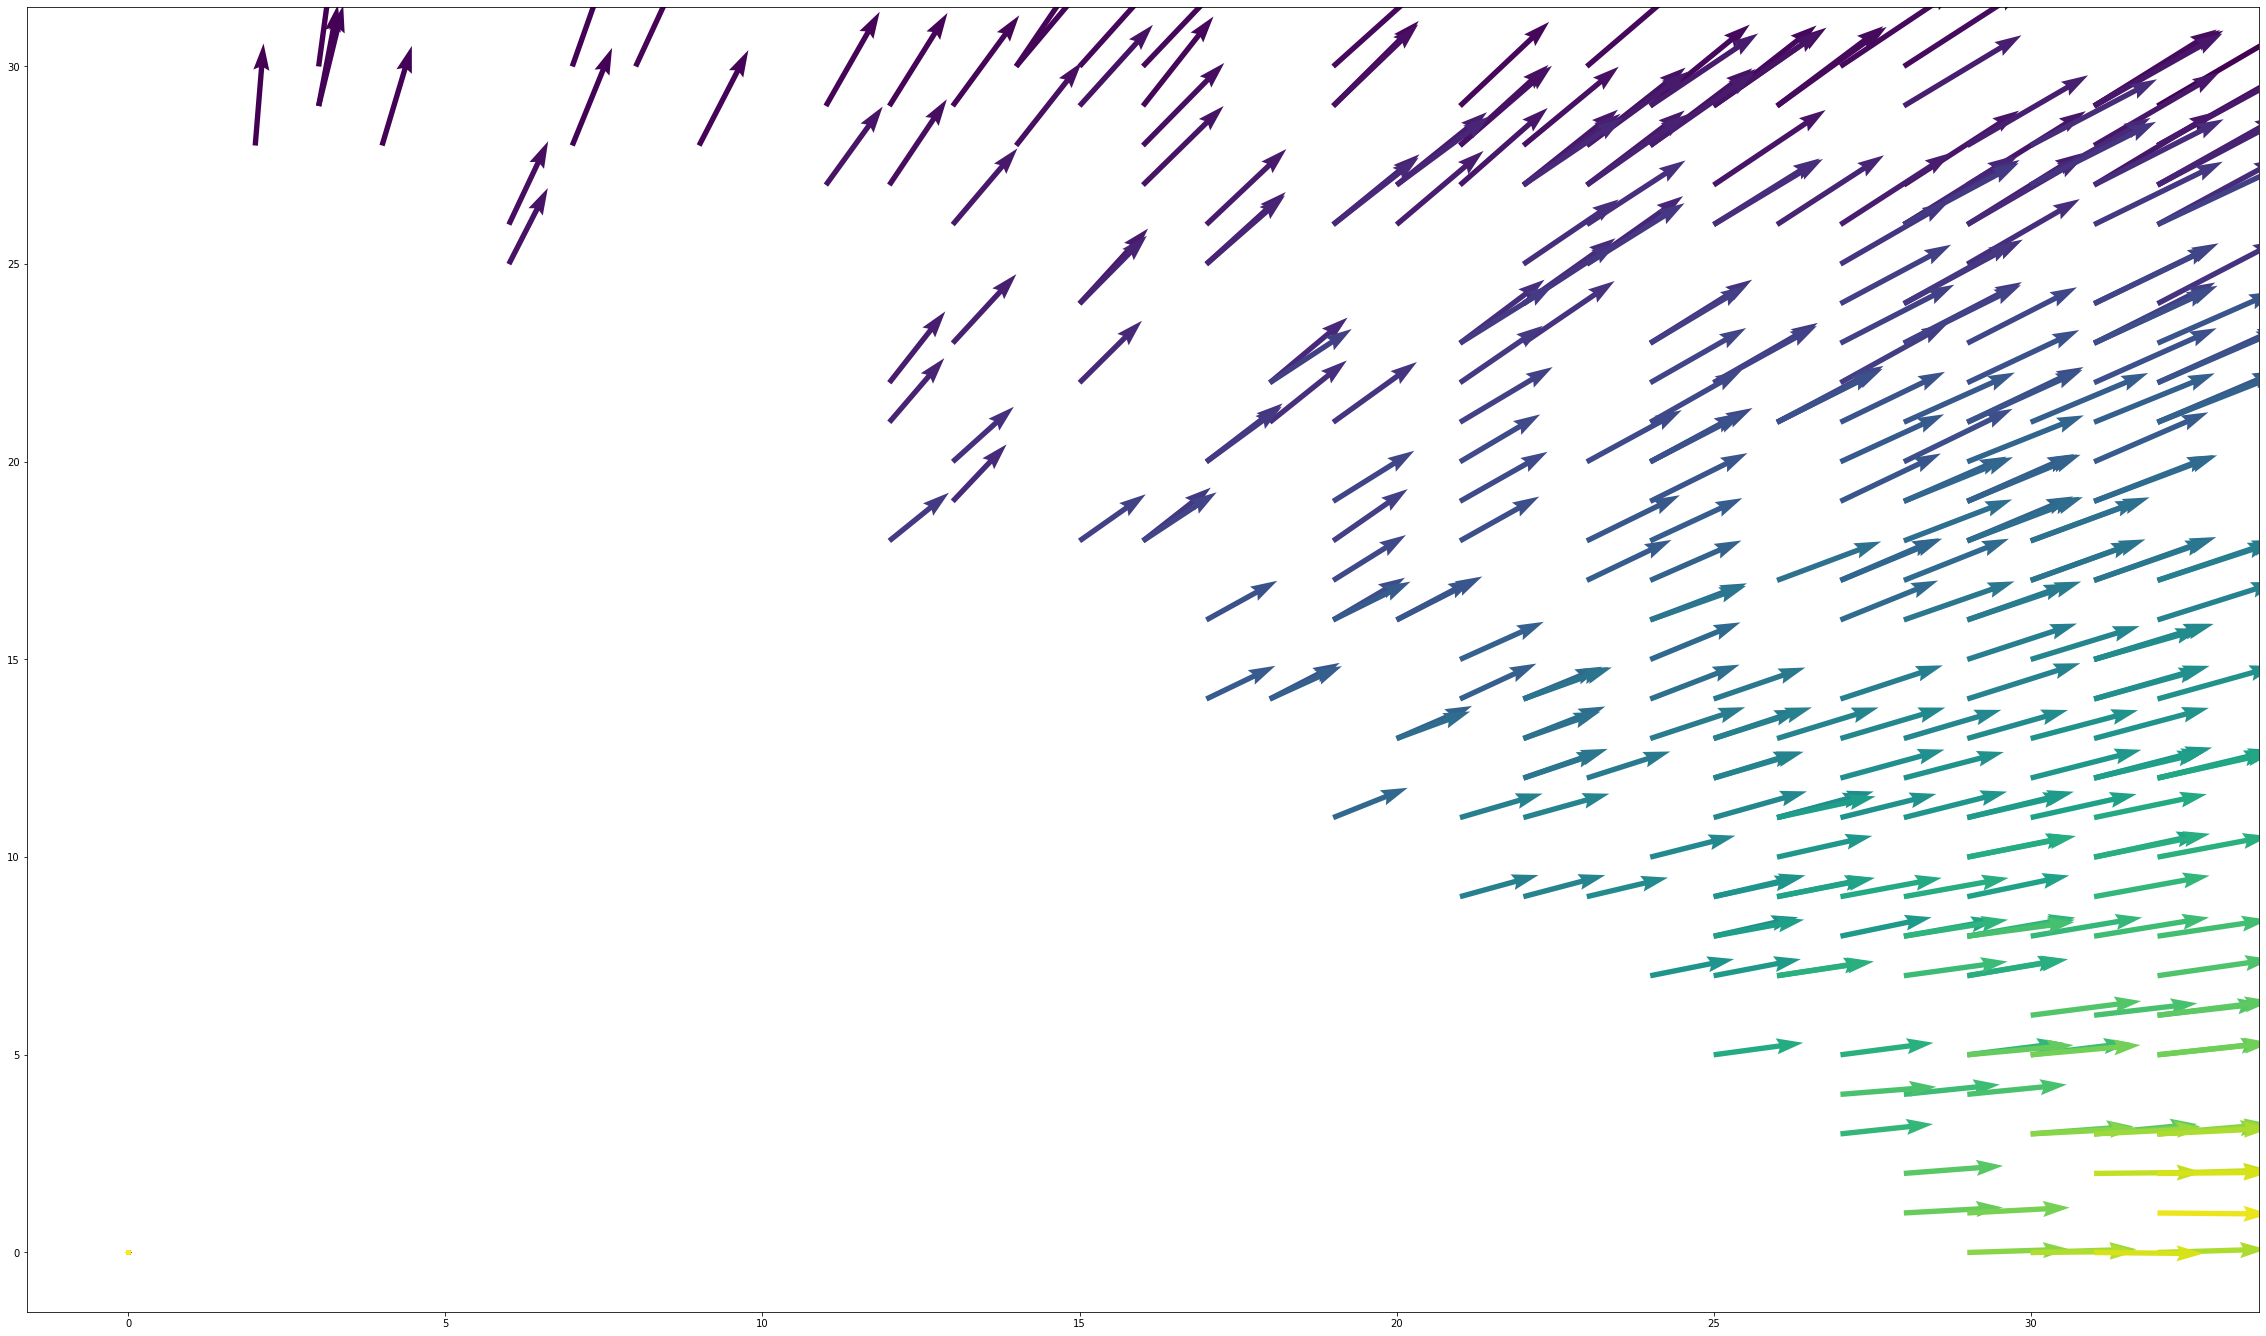

In [18]:
X, Y, U, V = zip(*motion_vectors_for_draw_16_64) 
plt.figure(figsize=(40, 24)) 
ax = plt.gca()
c = np.arange(len(motion_vectors_for_draw_16_64))
ax.quiver(X, Y, U, V, c, angles='xy') 
plt.draw() 
plt.show()

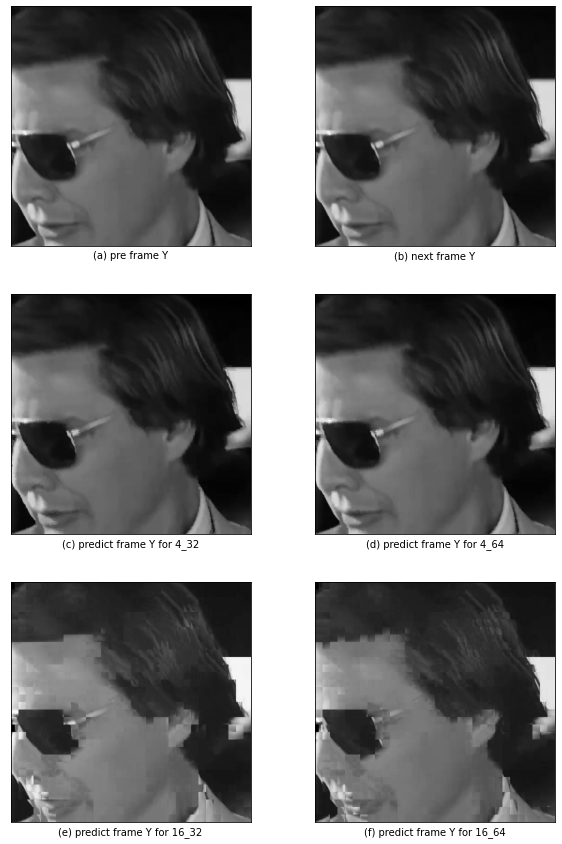

In [19]:
plt.figure(figsize=(10,15))

plt.subplot(321)
plt.xticks([])
plt.yticks([])
plt.xlabel('(a) pre frame Y')
plt.imshow(capture_1_Y, cmap='gray')

plt.subplot(322)
plt.xticks([])
plt.yticks([])
plt.xlabel('(b) next frame Y')
plt.imshow(capture_2_Y, cmap='gray')

plt.subplot(323)
plt.xticks([])
plt.yticks([])
plt.xlabel('(c) predict frame Y for 4_32')
plt.imshow(predict_image_4_32, cmap='gray')

plt.subplot(324)
plt.xticks([])
plt.yticks([])
plt.xlabel('(d) predict frame Y for 4_64')
plt.imshow(predict_image_4_64, cmap='gray')

plt.subplot(325)
plt.xticks([])
plt.yticks([])
plt.xlabel('(e) predict frame Y for 16_32')
plt.imshow(predict_image_16_32, cmap='gray')

plt.subplot(326)
plt.xticks([])
plt.yticks([])
plt.xlabel('(f) predict frame Y for 16_64')
plt.imshow(predict_image_16_64, cmap='gray')

### 3.2 得到残差图像

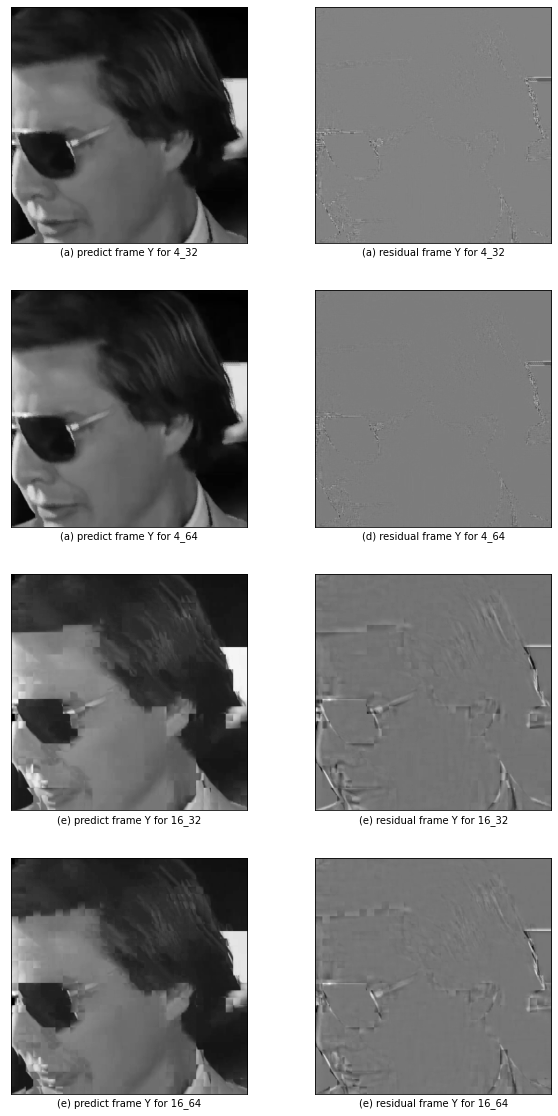

In [20]:
residual_image_4_32 = np.array(capture_2_Y - predict_image_4_32)
residual_image_4_64 = np.array(capture_2_Y - predict_image_4_64)
residual_image_16_32 = np.array(capture_2_Y - predict_image_16_32)
residual_image_16_64 = np.array(capture_2_Y - predict_image_16_64)

plt.figure(figsize=(10,20))
plt.subplot(421)
plt.xticks([])
plt.yticks([])
plt.xlabel('(a) predict frame Y for 4_32')
plt.imshow(predict_image_4_32, cmap='gray')

plt.subplot(422)
plt.xticks([])
plt.yticks([])
plt.xlabel('(a) residual frame Y for 4_32')
plt.imshow(residual_image_4_32, cmap='gray')

plt.subplot(423)
plt.xticks([])
plt.yticks([])
plt.xlabel('(a) predict frame Y for 4_64')
plt.imshow(predict_image_4_64, cmap='gray')

plt.subplot(424)
plt.xticks([])
plt.yticks([])
plt.xlabel('(d) residual frame Y for 4_64')
plt.imshow(residual_image_4_64, cmap='gray')

plt.subplot(425)
plt.xticks([])
plt.yticks([])
plt.xlabel('(e) predict frame Y for 16_32')
plt.imshow(predict_image_16_32, cmap='gray')

plt.subplot(426)
plt.xticks([])
plt.yticks([])
plt.xlabel('(e) residual frame Y for 16_32')
plt.imshow(residual_image_16_32, cmap='gray')

plt.subplot(427)
plt.xticks([])
plt.yticks([])
plt.xlabel('(e) predict frame Y for 16_64')
plt.imshow(predict_image_16_64, cmap='gray')

plt.subplot(428)
plt.xticks([])
plt.yticks([])
plt.xlabel('(e) residual frame Y for 16_64')
plt.imshow(residual_image_16_64, cmap='gray')

In [21]:
residual_image_4_32

array([[  0.,   1.,   1., ...,   0.,   0.,   0.],
       [ -2.,  -1.,   1., ...,   0.,   0.,   0.],
       [ -1.,  -1.,  -2., ...,   0.,   0.,   0.],
       ...,
       [  2.,   2.,  -1., ...,   0.,   3.,   4.],
       [ -5.,  -5.,  -1., ...,   0.,   1.,   3.],
       [-16., -15., -14., ...,   1.,   2.,   2.]])

In [22]:
sub_image_y_4_32 = divide_img(residual_image_4_32, 4)
sub_image_y_4_32[0]

array([[ 0.,  1.,  1.,  1.],
       [-2., -1.,  1.,  1.],
       [-1., -1., -2., -2.],
       [-1.,  0.,  0.,  0.]])

*坐上角的值不是最大值*

In [23]:
sub_image_y_4_32 = [np.float32(i) for i in sub_image_y_4_32]
y_dct_4_32_no_array = merge_dct(sub_image_y_4_32)
y_dct_4_32_no_array[0]

array([[-1.25      , -1.4418621 , -0.75      , -0.21455535],
       [ 1.9830582 , -0.92677677, -0.13529903,  0.23743689],
       [ 2.25      ,  0.13529903, -0.25      , -0.32664075],
       [-1.0920076 ,  2.237437  ,  0.32664075, -0.57322335]],
      dtype=float32)

*使用反变换进行测试后发现可以复原*

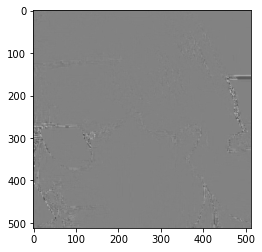

In [24]:
ori_img_recover = merge_idct(y_dct_4_32_no_array)
recover_img = merge_image(ori_img_recover, predict_image_4_32, 4)
plt.imshow(recover_img, cmap='gray')

---
# 基本原理

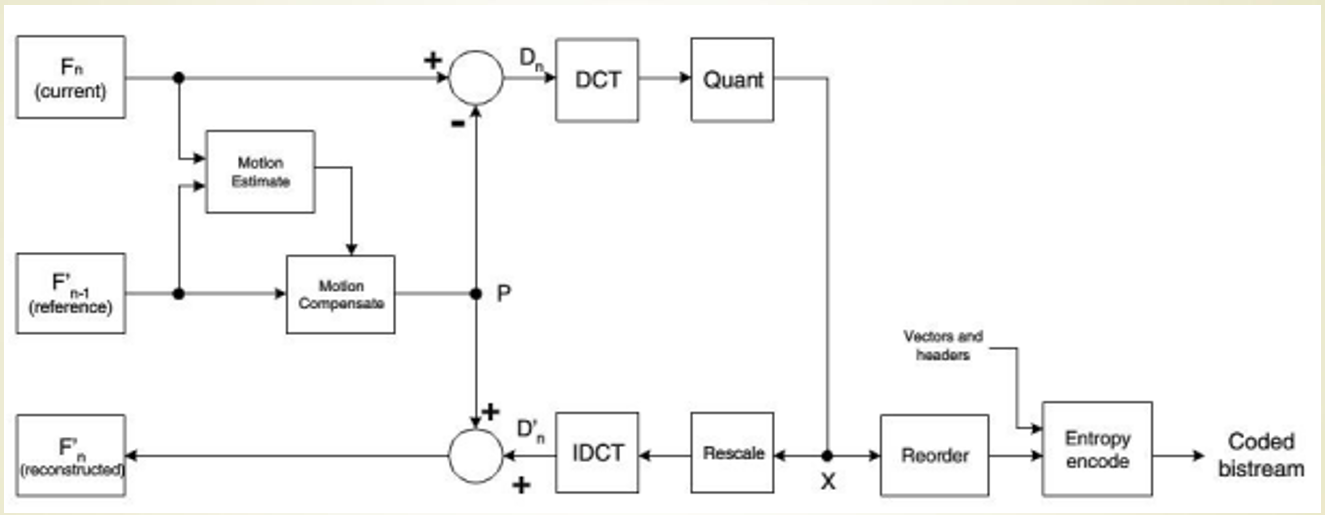

## 4. DCT

### 4.1 DCT变换

In [25]:
sub_image_y_4_32 = divide_img(residual_image_4_32, 4)
sub_image_y_4_64 = divide_img(residual_image_4_64, 4)
sub_image_y_16_32 = divide_img(residual_image_16_32, 16)
sub_image_y_16_64 = divide_img(residual_image_16_64, 16)

sub_image_y_4_32 = [np.float32(i) for i in sub_image_y_4_32]
y_dct_4_32_no_array = merge_dct(sub_image_y_4_32)

sub_image_y_4_64 = [np.float32(i) for i in sub_image_y_4_64]
y_dct_4_64_no_array = merge_dct(sub_image_y_4_64)

sub_image_y_16_32 = [np.float32(i) for i in sub_image_y_16_32]
y_dct_16_32_no_array = merge_dct(sub_image_y_16_32)

sub_image_y_16_64 = [np.float32(i) for i in sub_image_y_16_64]
y_dct_16_64_no_array = merge_dct(sub_image_y_16_64)

### 4.2 量化

观察数据后发现，如果除以4，大部分都会变成0，会影响图像数据，因此尝试用步长2量化

In [26]:
y_dct_4_32_no_array_qutisize_4 = np.round(y_dct_4_32_no_array / 4)
y_dct_4_64_no_array_qutisize_4 = np.round(y_dct_4_64_no_array / 4)
y_dct_16_32_no_array_qutisize_4 = np.round(y_dct_16_32_no_array / 4)
y_dct_16_64_no_array_qutisize_4 = np.round(y_dct_16_64_no_array / 4)

In [27]:
y_dct_4_32_no_array_qutisize_2 = np.round(y_dct_4_32_no_array / 2)
y_dct_4_64_no_array_qutisize_2 = np.round(y_dct_4_64_no_array / 2)
y_dct_16_32_no_array_qutisize_2 = np.round(y_dct_16_32_no_array / 2)
y_dct_16_64_no_array_qutisize_2 = np.round(y_dct_16_64_no_array / 2)

In [28]:
y_dct_16_32_no_array_qutisize_4[:3], y_dct_16_32_no_array[:3]

(array([[[ 50.,  42.,   1., -17.,   1.,   9.,  -0.,  -7.,   0.,   6.,
           -0.,  -5.,  -0.,   5.,   0.,  -5.],
         [ 18., -10.,  -1.,   4.,  -2.,  -1.,  -0.,   1.,  -0.,  -1.,
           -0.,   1.,   0.,  -1.,  -0.,   1.],
         [  1.,   4.,   0.,  -3.,   1.,   1.,  -1.,  -1.,   0.,   0.,
            0.,  -0.,  -0.,   1.,   0.,  -1.],
         [  4.,  -0.,  -1.,   1.,  -1.,  -1.,   1.,   0.,  -0.,   0.,
           -1.,   0.,   0.,  -0.,   0.,   0.],
         [  3.,  -1.,   1.,  -0.,   0.,  -0.,  -0.,   0.,   0.,  -0.,
            0.,   0.,   0.,  -0.,  -0.,  -0.],
         [ -1.,   2.,  -0.,  -0.,  -0.,   0.,   0.,  -0.,   0.,   0.,
           -0.,  -0.,  -0.,   0.,  -0.,   0.],
         [  0.,  -0.,   0.,   0.,   1.,  -0.,  -0.,  -0.,   0.,  -0.,
           -0.,  -0.,   0.,  -0.,   0.,   0.],
         [  1.,  -1.,   0.,   0.,  -0.,   0.,   0.,   0.,  -0.,   0.,
           -0.,  -0.,  -0.,   0.,   0.,  -0.],
         [  0.,  -0.,  -0.,   0.,   0.,  -0.,  -0.,   0.,   0., 

### 4.3 反量化

In [29]:
y_dct_4_32_no_array_qutisize_4_reverse = y_dct_4_32_no_array_qutisize_4 * 4
y_dct_4_64_no_array_qutisize_4_reverse = y_dct_4_64_no_array_qutisize_4 * 4
y_dct_16_32_no_array_qutisize_4_reverse = y_dct_16_32_no_array_qutisize_4 * 4
y_dct_16_64_no_array_qutisize_4_reverse = y_dct_16_64_no_array_qutisize_4 * 4

In [30]:
y_dct_4_32_no_array_qutisize_2_reverse = y_dct_4_32_no_array_qutisize_2 * 2
y_dct_4_64_no_array_qutisize_2_reverse = y_dct_4_64_no_array_qutisize_2 * 2
y_dct_16_32_no_array_qutisize_2_reverse = y_dct_16_32_no_array_qutisize_2 * 2
y_dct_16_64_no_array_qutisize_2_reverse = y_dct_16_64_no_array_qutisize_2 * 2

### 4.4 反变换

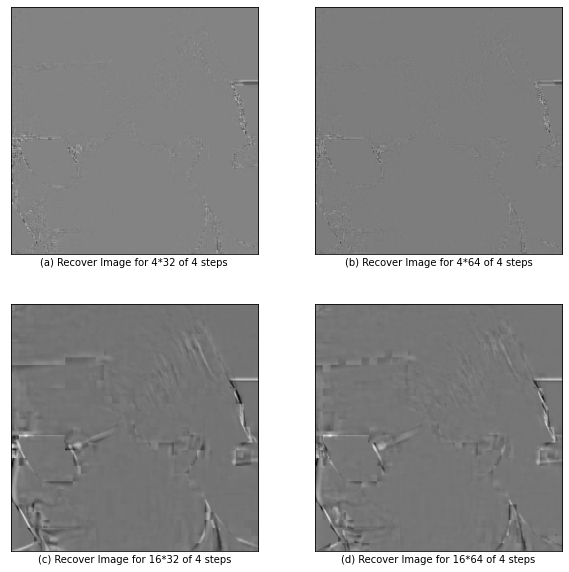

In [31]:
y_idct_4_32_no_array_4 = merge_idct(y_dct_4_32_no_array_qutisize_4_reverse)
y_idct_4_32_recover_4 = merge_image(y_idct_4_32_no_array_4, capture_2_Y, 4)
# plt.imshow(recover_img, cmap='gray')

y_idct_4_64_no_array_4 = merge_idct(y_dct_4_64_no_array_qutisize_4_reverse)
y_idct_4_64_recover_4 = merge_image(y_idct_4_64_no_array_4, capture_2_Y, 4)

y_idct_16_32_no_array_4 = merge_idct(y_dct_16_32_no_array_qutisize_4_reverse)
y_idct_16_32_recover_4 = merge_image(y_idct_16_32_no_array_4, capture_2_Y, 16)

y_idct_16_64_no_array_4 = merge_idct(y_dct_16_64_no_array_qutisize_4_reverse)
y_idct_16_64_recover_4 = merge_image(y_idct_16_64_no_array_4, capture_2_Y, 16)

plt.figure(figsize=(10, 10))

plt.subplot(221)
plt.xticks([])
plt.yticks([])
plt.xlabel('(a) Recover Image for 4*32 of 4 steps')
plt.imshow(y_idct_4_32_recover_4, cmap='gray')

plt.subplot(222)
plt.xticks([])
plt.yticks([])
plt.xlabel('(b) Recover Image for 4*64 of 4 steps')
plt.imshow(y_idct_4_64_recover_4, cmap='gray')

plt.subplot(223)
plt.xticks([])
plt.yticks([])
plt.xlabel('(c) Recover Image for 16*32 of 4 steps')
plt.imshow(y_idct_16_32_recover_4, cmap='gray')

plt.subplot(224)
plt.xticks([])
plt.yticks([])
plt.xlabel('(d) Recover Image for 16*64 of 4 steps')
plt.imshow(y_idct_16_64_recover_4, cmap='gray')

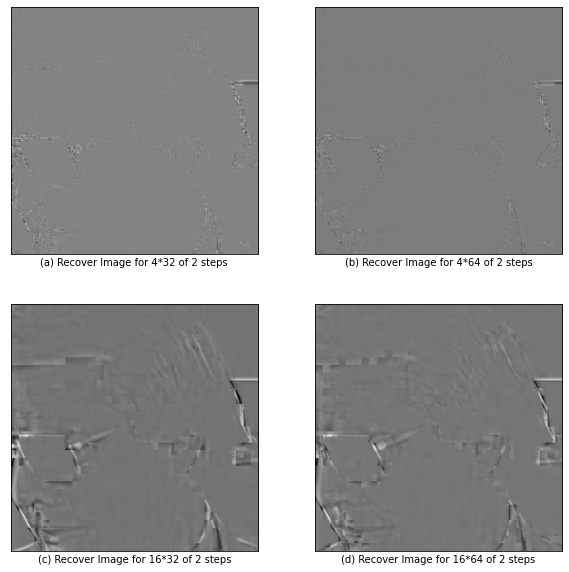

In [32]:
y_idct_4_32_no_array_2 = merge_idct(y_dct_4_32_no_array_qutisize_4_reverse)
y_idct_4_32_recover_2 = merge_image(y_idct_4_32_no_array_2, capture_2_Y, 4)

y_idct_4_64_no_array_2 = merge_idct(y_dct_4_64_no_array_qutisize_4_reverse)
y_idct_4_64_recover_2 = merge_image(y_idct_4_64_no_array_2, capture_2_Y, 4)

y_idct_16_32_no_array_2 = merge_idct(y_dct_16_32_no_array_qutisize_4_reverse)
y_idct_16_32_recover_2 = merge_image(y_idct_16_32_no_array_2, capture_2_Y, 16)

y_idct_16_64_no_array_2 = merge_idct(y_dct_16_64_no_array_qutisize_4_reverse)
y_idct_16_64_recover_2 = merge_image(y_idct_16_64_no_array_2, capture_2_Y, 16)

plt.figure(figsize=(10, 10))

plt.subplot(221)
plt.xticks([])
plt.yticks([])
plt.xlabel('(a) Recover Image for 4*32 of 2 steps')
plt.imshow(y_idct_4_32_recover_2, cmap='gray')

plt.subplot(222)
plt.xticks([])
plt.yticks([])
plt.xlabel('(b) Recover Image for 4*64 of 2 steps')
plt.imshow(y_idct_4_64_recover_2, cmap='gray')

plt.subplot(223)
plt.xticks([])
plt.yticks([])
plt.xlabel('(c) Recover Image for 16*32 of 2 steps')
plt.imshow(y_idct_16_32_recover_2, cmap='gray')

plt.subplot(224)
plt.xticks([])
plt.yticks([])
plt.xlabel('(d) Recover Image for 16*64 of 2 steps')
plt.imshow(y_idct_16_64_recover_2, cmap='gray')

## 5. 重建

- 按索引保存的运动矢量如下
```py
motion_vectors[i*j+j][0], motion_vectors[i*j+j][1] = h, k
```


In [33]:
len(motion_vectors_16_64) == (width // 16) * (height // 16)

True

查看一下中间变量，便于理解

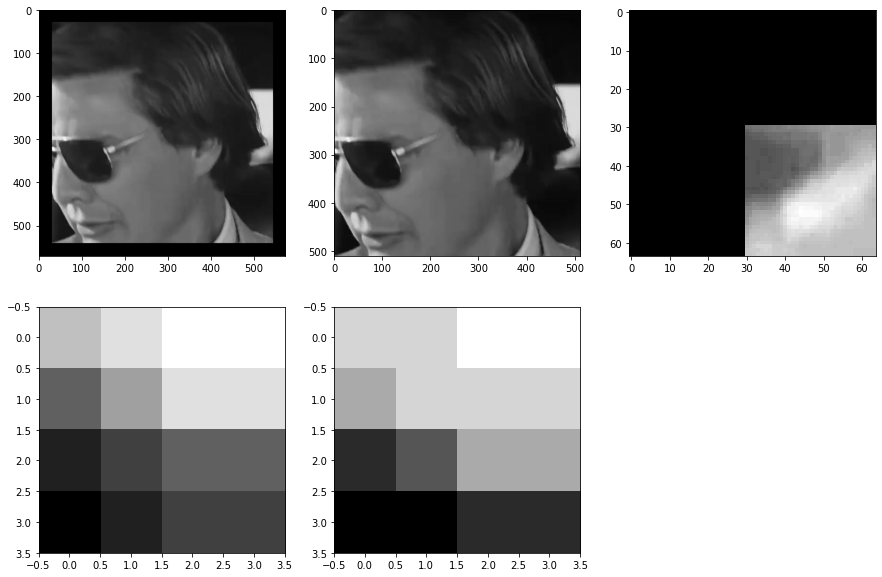

In [34]:
def get_preimage_motions(width, height, block_sizes, search_areas):

    width_num = width // block_sizes
    height_num = height // block_sizes
    # 运动向量个数
    vet_nums = width_num * height_num
    # 用来保存运动向量，保存坐标值
    # 先赋予空值
    motion_vectors = [[0, 0] for _ in range(vet_nums)]
#     motion_vectors_for_draw = [[0, 0, 0, 0] for _ in range(vet_nums)]
    
    similarity = 0
    num = 0
    end_num = search_areas//block_sizes
    
    # 计算间隔，用于补0
    interval = (search_areas-block_sizes)//2
    # 构造模板图像，对于上一帧图像加0
    mask_image_1 = np.zeros((width + interval*2, height + interval*2))
    mask_image_1[interval:mask_image_1.shape[0]-interval, interval:mask_image_1.shape[1]-interval] = capture_1_Y
    
    # ========================================
    plt.figure(figsize=(15,10))
    plt.subplot(231)
    plt.imshow(mask_image_1, cmap='gray')
    plt.subplot(232)
    plt.imshow(capture_1_Y, cmap='gray')
    # ========================================
    
    mask_width, mask_height = mask_image_1.shape

    predict_image = np.zeros(capture_1_Y.shape)    
    
#     count = 0
    for i in range(height_num)[0:1]:
        for j in range(width_num)[0:1]:
#             count += 1
    #         print(f'==================i:{i}=j:{j}==count:{count}=====================')
            temp_image = capture_2_Y[i*block_sizes:(i+1)*block_sizes, j*block_sizes:(j+1)*block_sizes]
            mask_image = mask_image_1[i*block_sizes:i*block_sizes+search_areas, j*block_sizes:j*block_sizes+search_areas]
            #  给定初值，用于比较
            temp_res = mse(mask_image[:block_sizes, :block_sizes], temp_image)
            
            count_num = 0
            for k in range(end_num):
                for h in range(end_num):
                    count_num += 1
                    # 取一个模板
                    temp_mask = mask_image[k*block_sizes:(k+1)*block_sizes, h*block_sizes:(h+1)*block_sizes]
                    # 计算mad
                    res = mad(temp_mask, temp_image)
                    # 比较，如果大于默认值，则将其设为默认值，并将预测图像赋值，替代当前运动矢量\\
                    if res <= temp_res:
                        temp_res = res
                        motion_vectors[i*j+j][0], motion_vectors[i*j+j][1] = h, k
#                         motion_vectors_for_draw[i*j+j][0], motion_vectors_for_draw[i*j+j][1], motion_vectors_for_draw[i*j+j][2], motion_vectors_for_draw[i*j+j][3] = i+k, height_num-(j+h), i+interval/block_sizes, height_num-(j+interval/block_sizes)
                        predict_image[i*block_sizes:(i+1)*block_sizes, j*block_sizes:(j+1)*block_sizes] = temp_mask
                        
                        # ========================================
                        plt.subplot(233)
                        plt.imshow(mask_image, cmap='gray')
                        plt.subplot(234)
                        plt.imshow(temp_image, cmap='gray')
                        plt.subplot(235)
                        plt.imshow(temp_mask, cmap='gray')
#                         print(f'================No.{count_num} h: {h}  k: {k}==================')
                        # ========================================
                        
#                         print(motion_vectors_for_draw[i*j+j])
#                     break
#                 break
#             break
#         break
    return np.array(predict_image, dtype=np.uint8), np.array(motion_vectors)

a, b = get_preimage_motions(width, height, 4, 64)

In [35]:
b[:3]

array([[9, 8],
       [0, 0],
       [0, 0]])

============[1 1]===========
Temp_image's shape: (16, 16)
[[-6. -6. -5. -6. -6. -6. -7. -7. -7. -7. -6. -6. -5. -5. -5. -5.]
 [-6. -6. -5. -6. -6. -6. -7. -7. -7. -7. -6. -6. -6. -6. -5. -5.]
 [-6. -7. -6. -7. -7. -7. -8. -8. -8. -8. -8. -7. -6. -6. -5. -5.]
 [-4. -6. -6. -5. -7. -7. -8. -8. -8. -8. -8. -7. -7. -7. -6. -6.]
 [-4. -5. -6. -6. -7. -7. -8. -8. -8. -8. -7. -7. -6. -6. -5. -5.]
 [-1. -3. -4. -3. -4. -4. -6. -6. -6. -6. -5. -5. -4. -4. -3. -3.]
 [-1. -2. -2. -2. -3. -2. -4. -4. -4. -4. -3. -3. -2. -2. -1. -1.]
 [-1. -3. -1.  0. -3. -3. -4. -3. -3. -3. -2. -2. -2. -2. -1. -1.]
 [-1. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -1. -1.  0.  0.]
 [-1. -1. -2. -2. -1. -1. -2. -2. -2. -2. -2. -2. -1. -1.  0.  0.]
 [-1. -1. -1. -2. -1. -1. -1. -1. -1. -1. -3. -1. -1. -1.  0.  0.]
 [-1. -1. -1. -2.  0.  0. -1. -1. -1. -1. -3. -1. -2. -2. -1. -1.]
 [-3. -3. -3. -3. -2. -2. -2. -2. -2. -2. -1. -1. -1. -1.  0.  0.]
 [-3. -3. -3. -3. -2. -2. -2. -3. -3. -3. -1. -1. -1. -1.  0.  0.]
 [-3

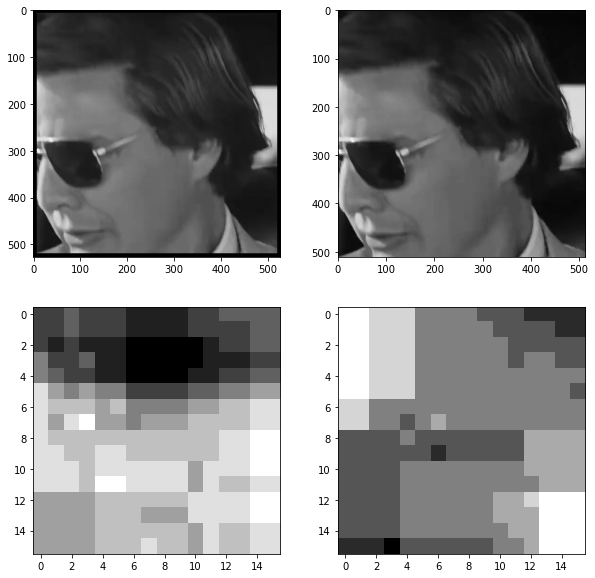

In [36]:
# 传入整个图像的width, height, block大小，搜索范围大小，运动矢量，残差图像，以及上一帧图像
def restruct_image(width, height, block_sizes, search_areas, motion_vectors, residual_image, pre_frame):

    width_num = width // block_sizes
    height_num = height // block_sizes
    # 运动向量个数
    vet_nums = width_num * height_num
    
    end_num = search_areas//block_sizes
    
    # 计算间隔，用于补0
    interval = (search_areas-block_sizes)//2
    # 构造模板图像，对于上一帧图像加0
    mask_image_1 = np.zeros((width + interval*2, height + interval*2))
    mask_image_1[interval:mask_image_1.shape[0]-interval, interval:mask_image_1.shape[1]-interval] = capture_1_Y
    
    # ========================================
    plt.figure(figsize=(10,10))
    plt.subplot(221)
    plt.imshow(mask_image_1, cmap='gray')
    plt.subplot(222)
    plt.imshow(capture_1_Y, cmap='gray')
    # ========================================
    
    restruct_image = np.zeros((width, height), dtype='int')
    
    for i in range(height_num)[3:]:
        for j in range(width_num)[3:]:
            print(f'============{motion_vectors[i*j+j]}===========')
            temp_image = residual_image[i*block_sizes:(i+1)*block_sizes, j*block_sizes:(j+1)*block_sizes]
            mask_image = mask_image_1[i*block_sizes:i*block_sizes+search_areas, j*block_sizes:j*block_sizes+search_areas]
            #  给定初值，用于比较
            
#             k, h = motion_vectors[i*j+j][0], motion_vectors[i*j+j][1]
            k, h = 1, 0
            restruct_image[i*block_sizes:(i+1)*block_sizes, j*block_sizes:(j+1)*block_sizes] = temp_image + mask_image[k*block_sizes:(k+1)*block_sizes, h*block_sizes:(h+1)*block_sizes]
#             except:
#                 restruct_image[i*block_sizes:(i+1)*block_sizes, j*block_sizes:(j+1)*block_sizes] = temp_image + mask_image[:block_sizes, :block_sizes]
            
            # ========================================
            plt.subplot(223)
            plt.imshow(temp_image, cmap='gray')
            plt.subplot(224)
            plt.imshow(mask_image[k*block_sizes:(k+1)*block_sizes, h*block_sizes:(h+1)*block_sizes], cmap='gray')
            
            print(f'Temp_image\'s shape: {temp_image.shape}')
            print(temp_image)
            print(f'Mask_image\'s shape: {mask_image[k*block_sizes:(k+1)*block_sizes, h*block_sizes:(h+1)*block_sizes].shape}')
            print(mask_image[k*block_sizes:(k+1)*block_sizes, h*block_sizes:(h+1)*block_sizes])
            print(restruct_image[i*block_sizes:(i+1)*block_sizes, j*block_sizes:(j+1)*block_sizes])
            # ========================================
            
            break
        break
    return np.array(restruct_image, dtype=np.uint8)

a = restruct_image(width, height, 16, 32, motion_vectors_16_32, residual_image_16_32, capture_1_Y)

`运动矢量记录的有问题……暂时还没想好`

In [39]:
def restruct_image(width, height, block_sizes, search_areas, motion_vectors, residual_image, pre_frame):

    width_num = width // block_sizes
    height_num = height // block_sizes
    # 运动向量个数
    vet_nums = width_num * height_num
    
    end_num = search_areas//block_sizes
    
    # 计算间隔，用于补0
    interval = (search_areas-block_sizes)//2
    # 构造模板图像，对于上一帧图像加0
    mask_image_1 = np.zeros((width + interval*2, height + interval*2))
    mask_image_1[interval:mask_image_1.shape[0]-interval, interval:mask_image_1.shape[1]-interval] = pre_frame
    
    restruct_image = np.zeros((width, height))
    
    for i in range(height_num):
        for j in range(width_num):
            temp_image = residual_image[i*block_sizes:(i+1)*block_sizes, j*block_sizes:(j+1)*block_sizes]
            mask_image = mask_image_1[i*block_sizes:i*block_sizes+search_areas, j*block_sizes:j*block_sizes+search_areas]
            #  给定初值，用于比较
            
            k, h = motion_vectors[(i*j)+j][0], motion_vectors[(i*j)+j][1]
            restruct_image[i*block_sizes:(i+1)*block_sizes, j*block_sizes:(j+1)*block_sizes] = temp_image + mask_image[k*block_sizes:(k+1)*block_sizes, h*block_sizes:(h+1)*block_sizes]
    return np.array(restruct_image, dtype=np.uint8)
#     return sub_images

# a = restruct_image(width, height, 16, 64, motion_vectors_16_64, residual_image_16_64, capture_1_Y)

### 5.1 step=4 重建

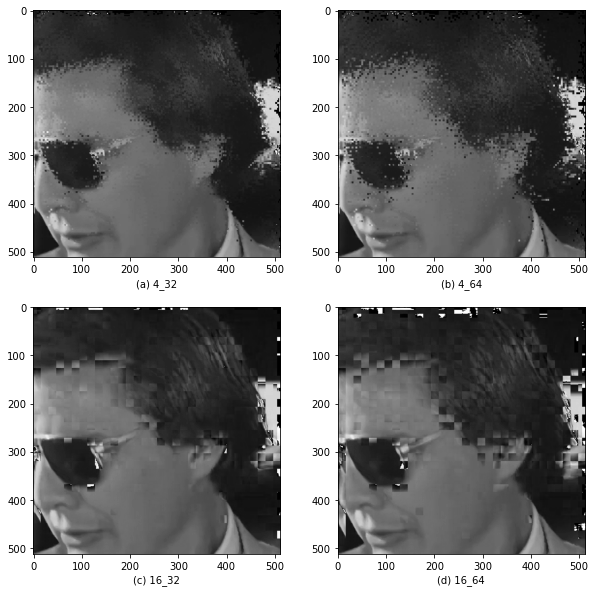

In [40]:
# restruct_image_4_32 = restruct_image(width, height, 4, 32, motion_vectors_4_32, residual_image_4_32, capture_1_Y)
# restruct_image_4_64 = restruct_image(width, height, 4, 64, motion_vectors_4_64, residual_image_4_64, capture_1_Y)
# restruct_image_16_32 = restruct_image(width, height, 16, 32, motion_vectors_16_32, residual_image_16_32, capture_1_Y)
# restruct_image_16_64 = restruct_image(width, height, 16, 64, motion_vectors_16_64, residual_image_16_64, capture_1_Y)

restruct_image_4_32 = restruct_image(width, height, 4, 32, motion_vectors_4_32, y_idct_4_32_recover_4, capture_1_Y)
restruct_image_4_64 = restruct_image(width, height, 4, 64, motion_vectors_4_64, y_idct_4_64_recover_4, capture_1_Y)
restruct_image_16_32 = restruct_image(width, height, 16, 32, motion_vectors_16_32, y_idct_16_32_recover_4, capture_1_Y)
restruct_image_16_64 = restruct_image(width, height, 16, 64, motion_vectors_16_64, y_idct_16_64_recover_4, capture_1_Y)

plt.figure(figsize=(10,10))
plt.subplot(221)
# plt.xticks([])
# plt.yticks([])
plt.xlabel('(a) 4_32')
plt.imshow(restruct_image_4_32, cmap='gray')

plt.subplot(222)
# plt.xticks([])
# plt.yticks([])
plt.xlabel('(b) 4_64')
plt.imshow(restruct_image_4_64, cmap='gray')

plt.subplot(223)
# plt.xticks([])
# plt.yticks([])
plt.xlabel('(c) 16_32')
plt.imshow(restruct_image_16_32, cmap='gray')

plt.subplot(224)
# plt.xticks([])
# plt.yticks([])
plt.xlabel('(d) 16_64')
plt.imshow(restruct_image_16_64, cmap='gray')

In [41]:
psnr_4_32_4 = compute_psnr(restruct_image_4_32, capture_2_Y)
psnr_4_64_4 = compute_psnr(restruct_image_4_64, capture_2_Y)
psnr_16_32_4 = compute_psnr(restruct_image_16_32, capture_2_Y)
psnr_16_64_4 = compute_psnr(restruct_image_16_64, capture_2_Y)

print(f'The psnr of 4_32_4 is {psnr_4_32_4:.4f}.')
print(f'The psnr of 4_64_4 is {psnr_4_64_4:.4f}.')
print(f'The psnr of 16_32_4 is {psnr_16_32_4:.4f}.')
print(f'The psnr of 16_64_4 is {psnr_16_64_4:.4f}.')

The psnr of 4_32_4 is 23.7509.
The psnr of 4_64_4 is 21.5199.
The psnr of 16_32_4 is 21.2245.
The psnr of 16_64_4 is 18.7281.


### 5.2 step=2 重建

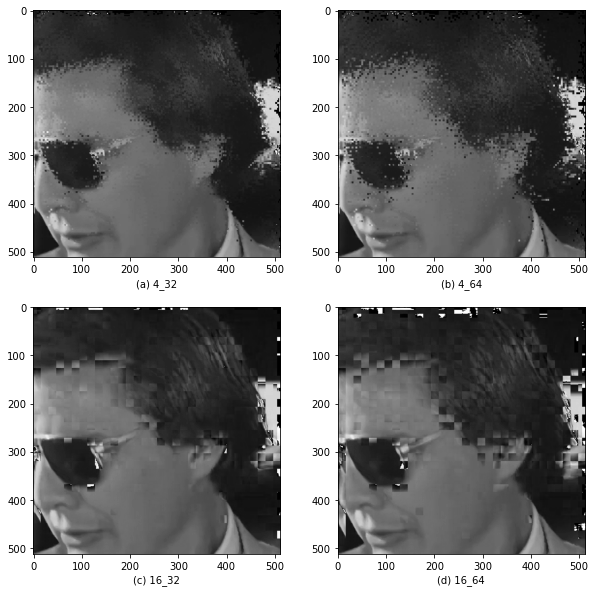

In [42]:
# restruct_image_4_32 = restruct_image(width, height, 4, 32, motion_vectors_4_32, residual_image_4_32, capture_1_Y)
# restruct_image_4_64 = restruct_image(width, height, 4, 64, motion_vectors_4_64, residual_image_4_64, capture_1_Y)
# restruct_image_16_32 = restruct_image(width, height, 16, 32, motion_vectors_16_32, residual_image_16_32, capture_1_Y)
# restruct_image_16_64 = restruct_image(width, height, 16, 64, motion_vectors_16_64, residual_image_16_64, capture_1_Y)

restruct_image_4_32_2 = restruct_image(width, height, 4, 32, motion_vectors_4_32, y_idct_4_32_recover_2, capture_1_Y)
restruct_image_4_64_2 = restruct_image(width, height, 4, 64, motion_vectors_4_64, y_idct_4_64_recover_2, capture_1_Y)
restruct_image_16_32_2 = restruct_image(width, height, 16, 32, motion_vectors_16_32, y_idct_16_32_recover_2, capture_1_Y)
restruct_image_16_64_2 = restruct_image(width, height, 16, 64, motion_vectors_16_64, y_idct_16_64_recover_2, capture_1_Y)

plt.figure(figsize=(10,10))
plt.subplot(221)
# plt.xticks([])
# plt.yticks([])
plt.xlabel('(a) 4_32')
plt.imshow(restruct_image_4_32_2, cmap='gray')

plt.subplot(222)
# plt.xticks([])
# plt.yticks([])
plt.xlabel('(b) 4_64')
plt.imshow(restruct_image_4_64_2, cmap='gray')

plt.subplot(223)
# plt.xticks([])
# plt.yticks([])
plt.xlabel('(c) 16_32')
plt.imshow(restruct_image_16_32_2, cmap='gray')

plt.subplot(224)
# plt.xticks([])
# plt.yticks([])
plt.xlabel('(d) 16_64')
plt.imshow(restruct_image_16_64_2, cmap='gray')

In [43]:
psnr_4_32_2 = compute_psnr(restruct_image_4_32_2, capture_2_Y)
psnr_4_64_2 = compute_psnr(restruct_image_4_64_2, capture_2_Y)
psnr_16_32_2 = compute_psnr(restruct_image_16_32_2, capture_2_Y)
psnr_16_64_2 = compute_psnr(restruct_image_16_64_2, capture_2_Y)

print(f'The psnr of 4_32_2 is {psnr_4_32_2:.4f}.')
print(f'The psnr of 4_64_2 is {psnr_4_64_2:.4f}.')
print(f'The psnr of 16_32_2 is {psnr_16_32_2:.4f}.')
print(f'The psnr of 16_64_2 is {psnr_16_64_2:.4f}.')

The psnr of 4_32_2 is 23.7509.
The psnr of 4_64_2 is 21.5199.
The psnr of 16_32_2 is 21.2245.
The psnr of 16_64_2 is 18.7281.


---